perform topic modeling on a small dataset in Python, you can use the Latent Dirichlet Allocation (LDA) algorithm from the gensim library. LDA is a probabilistic model that assumes that each document in a dataset is a mixture of a small number of topics, and that each word in the document is generated from one of those topics.

In [179]:
import csv, pandas as pd
from gensim import corpora
import re

## Reinigung

In [180]:
# Open the CSV file and read the sentences into a list
scenario = pd.read_excel('../Szenario/syntheticscenariosGPT4.xlsx')
scenario = scenario.drop('prompt', axis = 1)

In [181]:
scenario.dropna(subset=['scenario'], inplace=True)

In [182]:
scenario['scenario'] = \
scenario['scenario'].map(lambda x: x.lower())
scenario['scenario'].head(1)

0    personalized learning paths: ai-driven algorit...
Name: scenario, dtype: object

In [183]:
def split_sentence(sentence):
    words = sentence.split()
    unique_words = list(set(words))
    return unique_words

In [184]:
scenario['scenario_singlewords'] = scenario['scenario'].apply(split_sentence)

In [185]:
scenario['scenario_singlewords'].head(1)

0    [learning, weaknesses., create, paths:, indivi...
Name: scenario_singlewords, dtype: object

In [186]:
# Convert the lists in the scenario_singlewords column to tuples
scenario['scenario_singlewords'] = scenario['scenario_singlewords'].apply(tuple)

In [187]:
scenario['scenario_singlewords'] = scenario['scenario_singlewords'].apply(lambda x: [re.sub(r'[^\w\s]+', '', i) for i in x])

In [188]:
scenario

,tag,year,scenario,scenario_singlewords
0,education,2030,personalized learning paths: ai-driven algorit...,"[learning, weaknesses, create, paths, individu..."
1,education,2030,gamification widespread: interactive education...,"[are, interactive, students, learning, used, e..."
2,education,2030,remote learning dominance: virtual classrooms ...,"[dominance, learning, schools, norm, the, and,..."
3,education,2030,language learning revolution: advanced transla...,"[learning, accessible, multilingual, students,..."
4,education,2030,steam-focused curriculum: education prioritize...,"[creativity, drive, and, innovation, steamfocu..."
...,...,...,...,...
1149,society,2030,communities develop stronger support networks ...,"[networks, for, and, migrants, support, social..."
1150,society,2030,"marriage and family structures diversify, refl...","[diversify, structures, arrangements, and, fam..."
1151,society,2030,"cultural exchange programs expand, fostering i...","[countries, understanding, expand, and, exchan..."
1152,society,2030,"citizen activism increases, with people joinin...","[together, joining, people, and, environmental..."


## Stopwords und Synonyme filtern

In [189]:
import gensim
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np

In [215]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

# Add custom stopwords
custom_stop_words = ['promoting','fostering','becomes','advanced','reducing','ha', 'use', 'rise', 'led', 'lead', 'form', 'new', 'enable', 'continue', 'widespread']
stop_words = stop_words.union(custom_stop_words) 

In [216]:
# Create a WordNetLemmatizer object
lemmatizer = WordNetLemmatizer()

# Lemmatize each word in the list of single words
scenario['scenario_singlewords'] = [[lemmatizer.lemmatize(word) for word in word_list] for word_list in scenario['scenario_singlewords']]

In [217]:
# Combine all the single words into a single list
all_words = [word for word_list in scenario['scenario_singlewords'] for word in word_list]
# Filter out stopwords
all_words = [word for word in all_words if word not in stop_words]

In [218]:
# Filter out stopwords from the list of single words
scenario['scenario_singlewords'] = [[word for word in word_list if word not in stop_words] for word_list in scenario['scenario_singlewords']]

In [219]:
scenario['scenario_singlewords']

0       [learning, weakness, create, path, individuali...
1       [interactive, student, learning, used, engage,...
2       [dominance, learning, school, norm, course, cl...
3       [learning, accessible, multilingual, student, ...
4       [creativity, drive, innovation, steamfocused, ...
                              ...                        
1149    [network, migrant, support, social, integratio...
1150    [diversify, structure, arrangement, family, re...
1151    [country, understanding, expand, exchange, pro...
1152    [together, joining, people, environmental, iss...
1153    [communication, embrace, mobility, citizen, ad...
Name: scenario_singlewords, Length: 1154, dtype: object

In [220]:
unique_words = set(all_words)
count_unique_words = len(unique_words)
print(count_unique_words)

2260


## Visualisieren

In [221]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

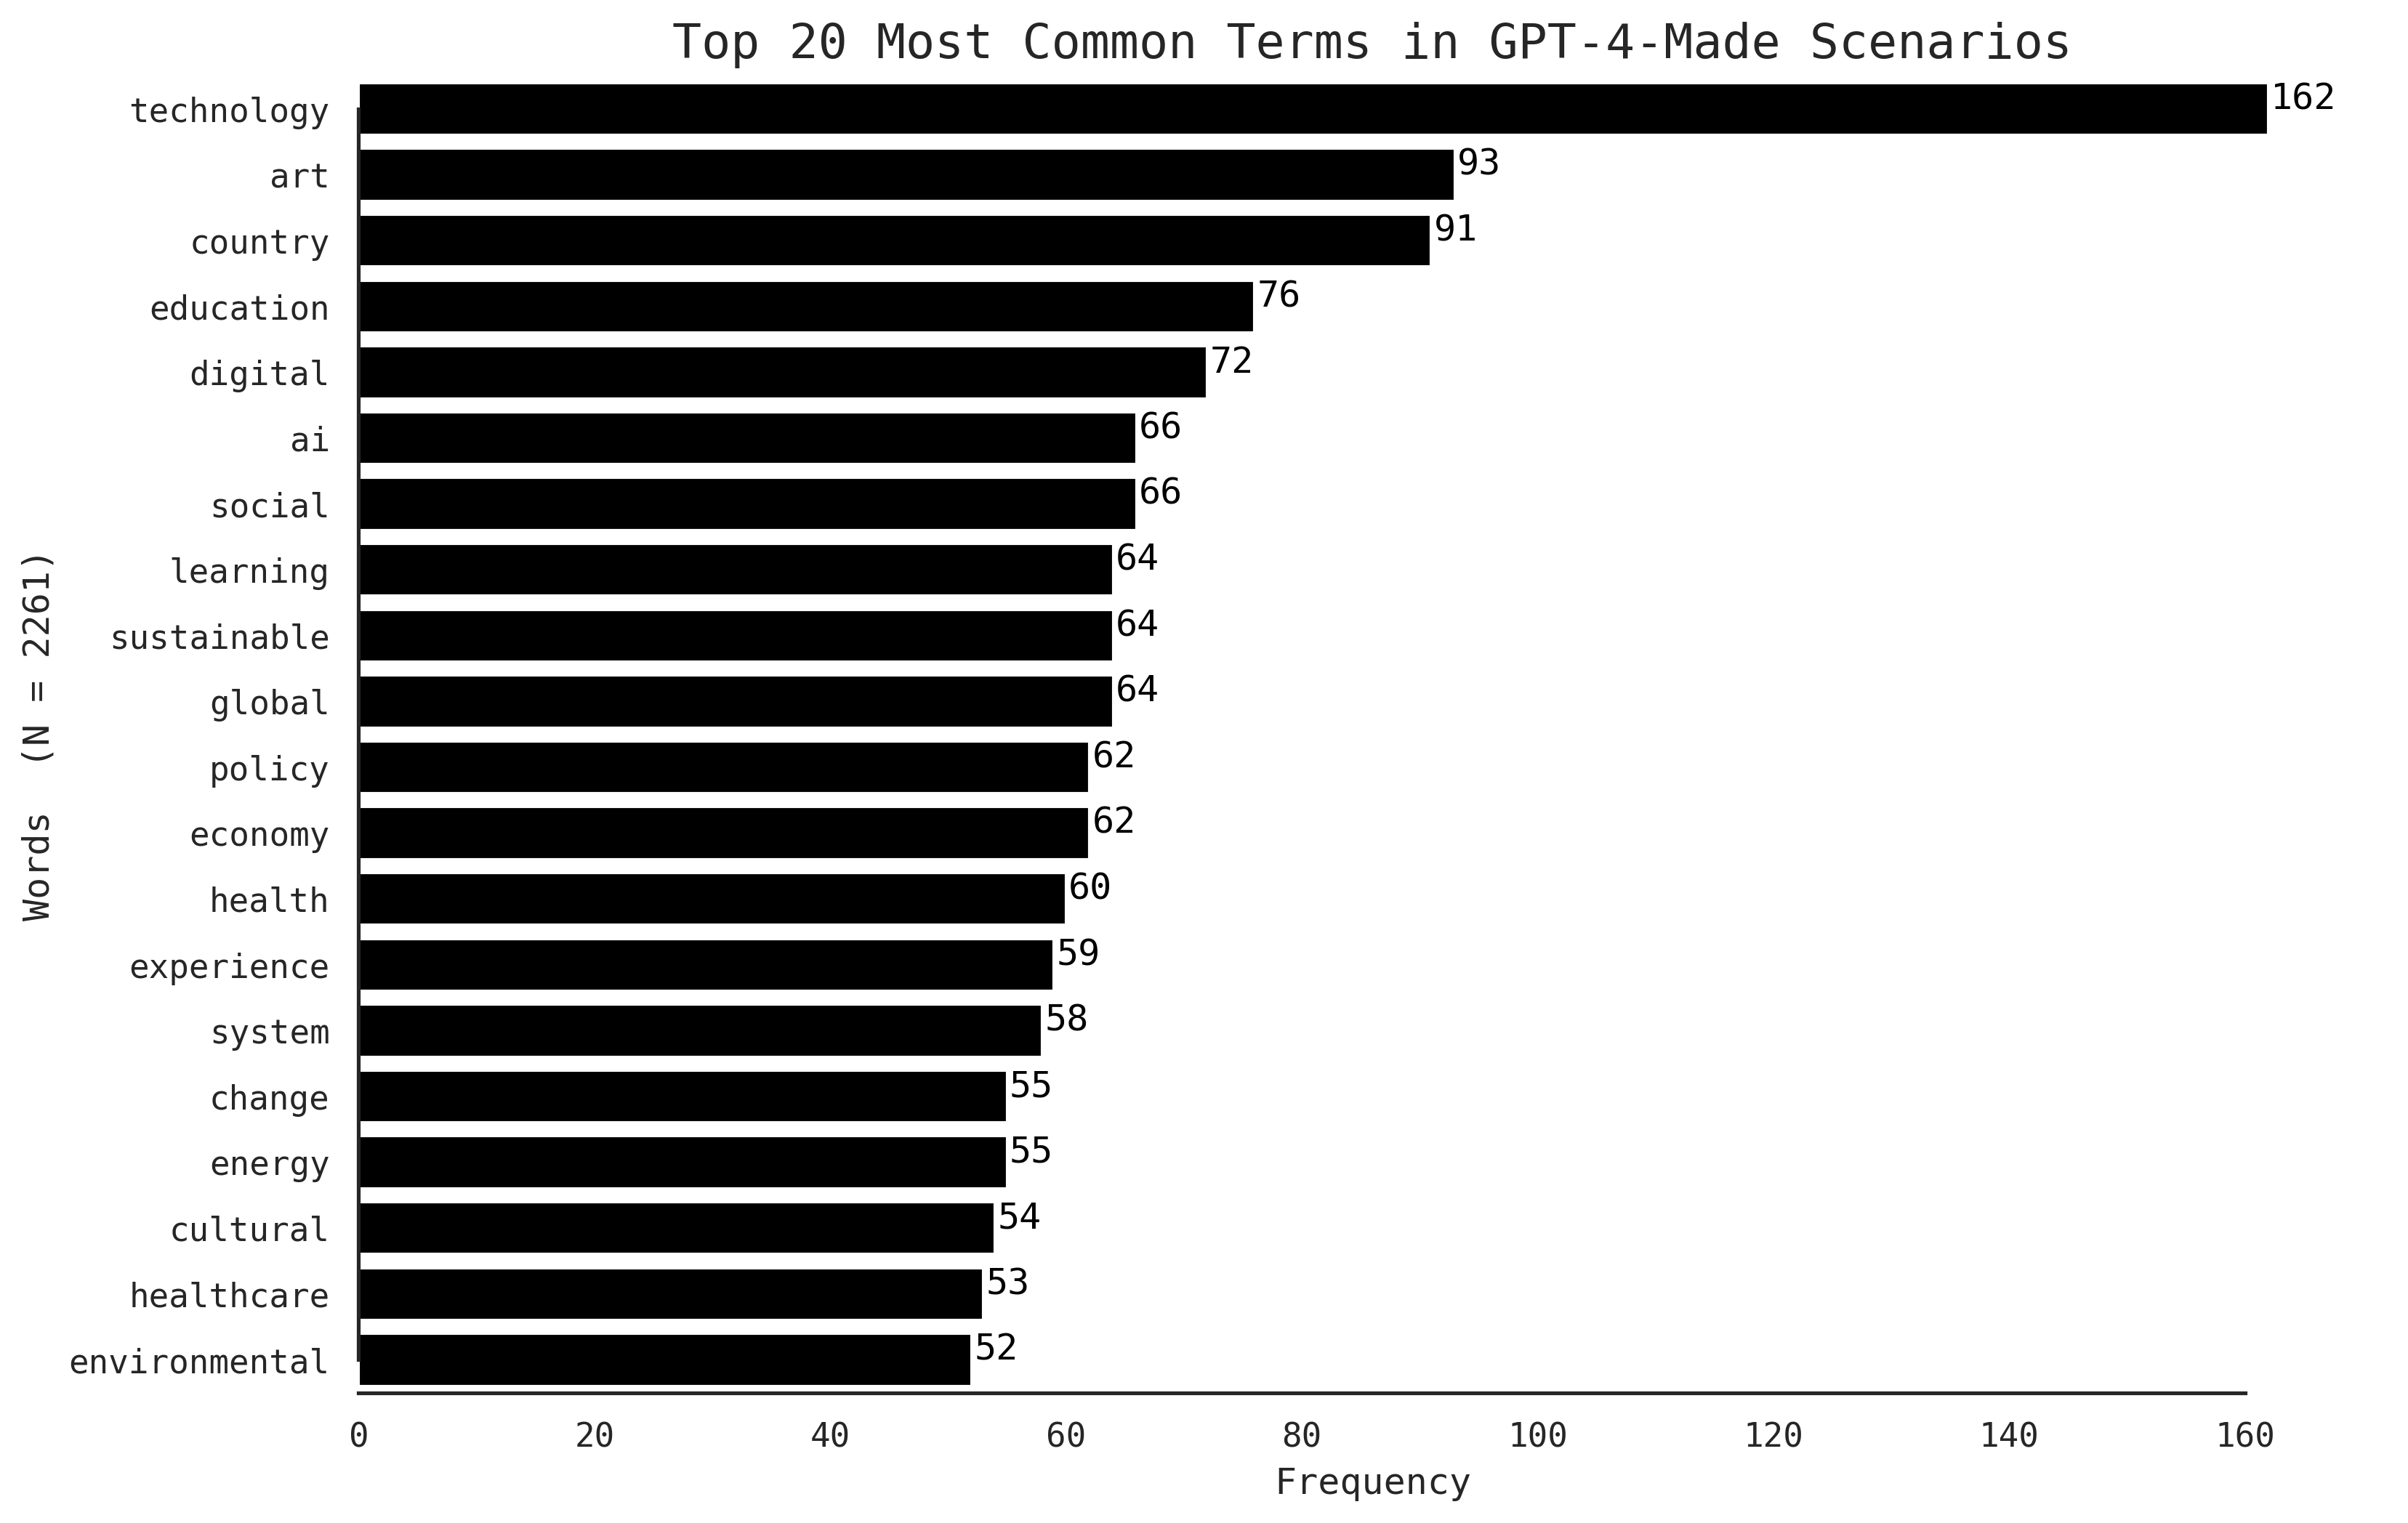

In [222]:
word_counts = Counter(all_words).most_common(20)
# Separate the words and their frequencies into separate lists
words, frequencies = zip(*word_counts)
words = list(words)
frequencies = list(frequencies)

# Set seaborn style and plot the bar chart
sns.set(style="white", font='monospace')
plt.figure(figsize=(12,8), dpi=300)
sns.barplot(x=frequencies, y=words, color='black') #45464c #192633 #7a96b3

# Add the frequency values as text
for i, v in enumerate(frequencies):
    plt.text(v + 0.2, i, str(v), color='black')

# Set the x-axis limit
plt.xlim(0, max(frequencies) + 10)

# Set the title and axis labels
plt.title('Top 20 Most Common Terms in GPT-4-Made Scenarios', fontsize = 16)
plt.xlabel('Frequency')
plt.ylabel('Words  (N = 2261)')

# Remove spines
sns.despine(trim=True)

plt.show()

# Sentiment Analyse

In [223]:
from transformers import AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from huggingface_hub import notebook_login
from transformers import AutoTokenizer
from transformers import pipeline
from datasets import load_metric
from tqdm import tqdm

In [224]:
unique_words=list(unique_words)
#unique_words

In [225]:
classifier = pipeline("sentiment-analysis",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)
prediction = classifier(unique_words)
print(prediction)

/Users/dianakozachek/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[[{'label': 'sadness', 'score': 0.03273037448525429}, {'label': 'joy', 'score': 0.7317086458206177}, {'label': 'love', 'score': 0.00744866207242012}, {'label': 'anger', 'score': 0.11163585633039474}, {'label': 'fear', 'score': 0.09074405580759048}, {'label': 'surprise', 'score': 0.025732412934303284}], [{'label': 'sadness', 'score': 0.10537731647491455}, {'label': 'joy', 'score': 0.39775019884109497}, {'label': 'love', 'score': 0.01857181452214718}, {'label': 'anger', 'score': 0.33999255299568176}, {'label': 'fear', 'score': 0.1239691972732544}, {'label': 'surprise', 'score': 0.014338892884552479}], [{'label': 'sadness', 'score': 0.06492595374584198}, {'label': 'joy', 'score': 0.166948601603508}, {'label': 'love', 'score': 0.009480456821620464}, {'label': 'anger', 'score': 0.4400634765625}, {'label': 'fear', 'score': 0.3004322350025177}, {'label': 'surprise', 'score': 0.01814928837120533}], [{'label': 'sadness', 'score': 0.048916254192590714}, {'label': 'joy', 'score': 0.72803676128387

In [226]:
scenario['year']=scenario['year'].astype(int)

In [227]:
df = pd.DataFrame(prediction)
df.head()

,0,1,2,3,4,5
0,"{'label': 'sadness', 'score': 0.03273037448525...","{'label': 'joy', 'score': 0.7317086458206177}","{'label': 'love', 'score': 0.00744866207242012}","{'label': 'anger', 'score': 0.11163585633039474}","{'label': 'fear', 'score': 0.09074405580759048}","{'label': 'surprise', 'score': 0.0257324129343..."
1,"{'label': 'sadness', 'score': 0.10537731647491...","{'label': 'joy', 'score': 0.39775019884109497}","{'label': 'love', 'score': 0.01857181452214718}","{'label': 'anger', 'score': 0.33999255299568176}","{'label': 'fear', 'score': 0.1239691972732544}","{'label': 'surprise', 'score': 0.0143388928845..."
2,"{'label': 'sadness', 'score': 0.06492595374584...","{'label': 'joy', 'score': 0.166948601603508}","{'label': 'love', 'score': 0.009480456821620464}","{'label': 'anger', 'score': 0.4400634765625}","{'label': 'fear', 'score': 0.3004322350025177}","{'label': 'surprise', 'score': 0.0181492883712..."
3,"{'label': 'sadness', 'score': 0.04891625419259...","{'label': 'joy', 'score': 0.7280367612838745}","{'label': 'love', 'score': 0.008224374614655972}","{'label': 'anger', 'score': 0.11123683303594589}","{'label': 'fear', 'score': 0.09628574550151825}","{'label': 'surprise', 'score': 0.0073000146076..."
4,"{'label': 'sadness', 'score': 0.00114948383998...","{'label': 'joy', 'score': 0.9948542714118958}","{'label': 'love', 'score': 0.0007426021620631218}","{'label': 'anger', 'score': 0.001378727494738996}","{'label': 'fear', 'score': 0.0007027916144579649}","{'label': 'surprise', 'score': 0.0011721805203..."


In [228]:
def transform_df(df):
    labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    new_df = pd.DataFrame(columns=labels)
    for i in range(df.shape[0]):
        row = {}
        for j in range(df.shape[1]):
            label = df.iloc[i, j]['label']
            score = df.iloc[i, j]['score']
            row[label] = score
        new_df = new_df.append(row, ignore_index=True)
    return new_df

new_df = transform_df(df)

In [229]:
new_df.head()

,sadness,joy,love,anger,fear,surprise
0,0.032730,0.731709,0.007449,0.111636,0.090744,0.025732
1,0.105377,0.397750,0.018572,0.339993,0.123969,0.014339
2,0.064926,0.166949,0.009480,0.440063,0.300432,0.018149
3,0.048916,0.728037,0.008224,0.111237,0.096286,0.007300
4,0.001149,0.994854,0.000743,0.001379,0.000703,0.001172


In [230]:
ss_emotions = pd.concat([scenario['year'],scenario['scenario'], new_df['sadness'], new_df['joy'], new_df['love'], new_df['anger'],new_df['fear'], new_df['surprise']], axis=1)
ss_emotions.head()

,year,scenario,sadness,joy,love,anger,fear,surprise
0,2030.0,personalized learning paths: ai-driven algorit...,0.032730,0.731709,0.007449,0.111636,0.090744,0.025732
1,2030.0,gamification widespread: interactive education...,0.105377,0.397750,0.018572,0.339993,0.123969,0.014339
2,2030.0,remote learning dominance: virtual classrooms ...,0.064926,0.166949,0.009480,0.440063,0.300432,0.018149
3,2030.0,language learning revolution: advanced transla...,0.048916,0.728037,0.008224,0.111237,0.096286,0.007300
4,2030.0,steam-focused curriculum: education prioritize...,0.001149,0.994854,0.000743,0.001379,0.000703,0.001172


In [231]:
ss_emotions = ss_emotions.dropna()
ss_emotions

,year,scenario,sadness,joy,love,anger,fear,surprise
0,2030.0,personalized learning paths: ai-driven algorit...,0.032730,0.731709,0.007449,0.111636,0.090744,0.025732
1,2030.0,gamification widespread: interactive education...,0.105377,0.397750,0.018572,0.339993,0.123969,0.014339
2,2030.0,remote learning dominance: virtual classrooms ...,0.064926,0.166949,0.009480,0.440063,0.300432,0.018149
3,2030.0,language learning revolution: advanced transla...,0.048916,0.728037,0.008224,0.111237,0.096286,0.007300
4,2030.0,steam-focused curriculum: education prioritize...,0.001149,0.994854,0.000743,0.001379,0.000703,0.001172
...,...,...,...,...,...,...,...,...
1149,2030.0,communities develop stronger support networks ...,0.047524,0.793979,0.016992,0.068583,0.060571,0.012350
1150,2030.0,"marriage and family structures diversify, refl...",0.137871,0.346599,0.011043,0.296932,0.194225,0.013329
1151,2030.0,"cultural exchange programs expand, fostering i...",0.001810,0.786085,0.202639,0.003486,0.002992,0.002989
1152,2030.0,"citizen activism increases, with people joinin...",0.017699,0.767515,0.017078,0.178784,0.014994,0.003929


In [233]:
#ss_emotions.to_csv('gpt4_scenarios_sentiment_analysis_full.csv', index = True)

## Visualize

In [234]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib as mpl

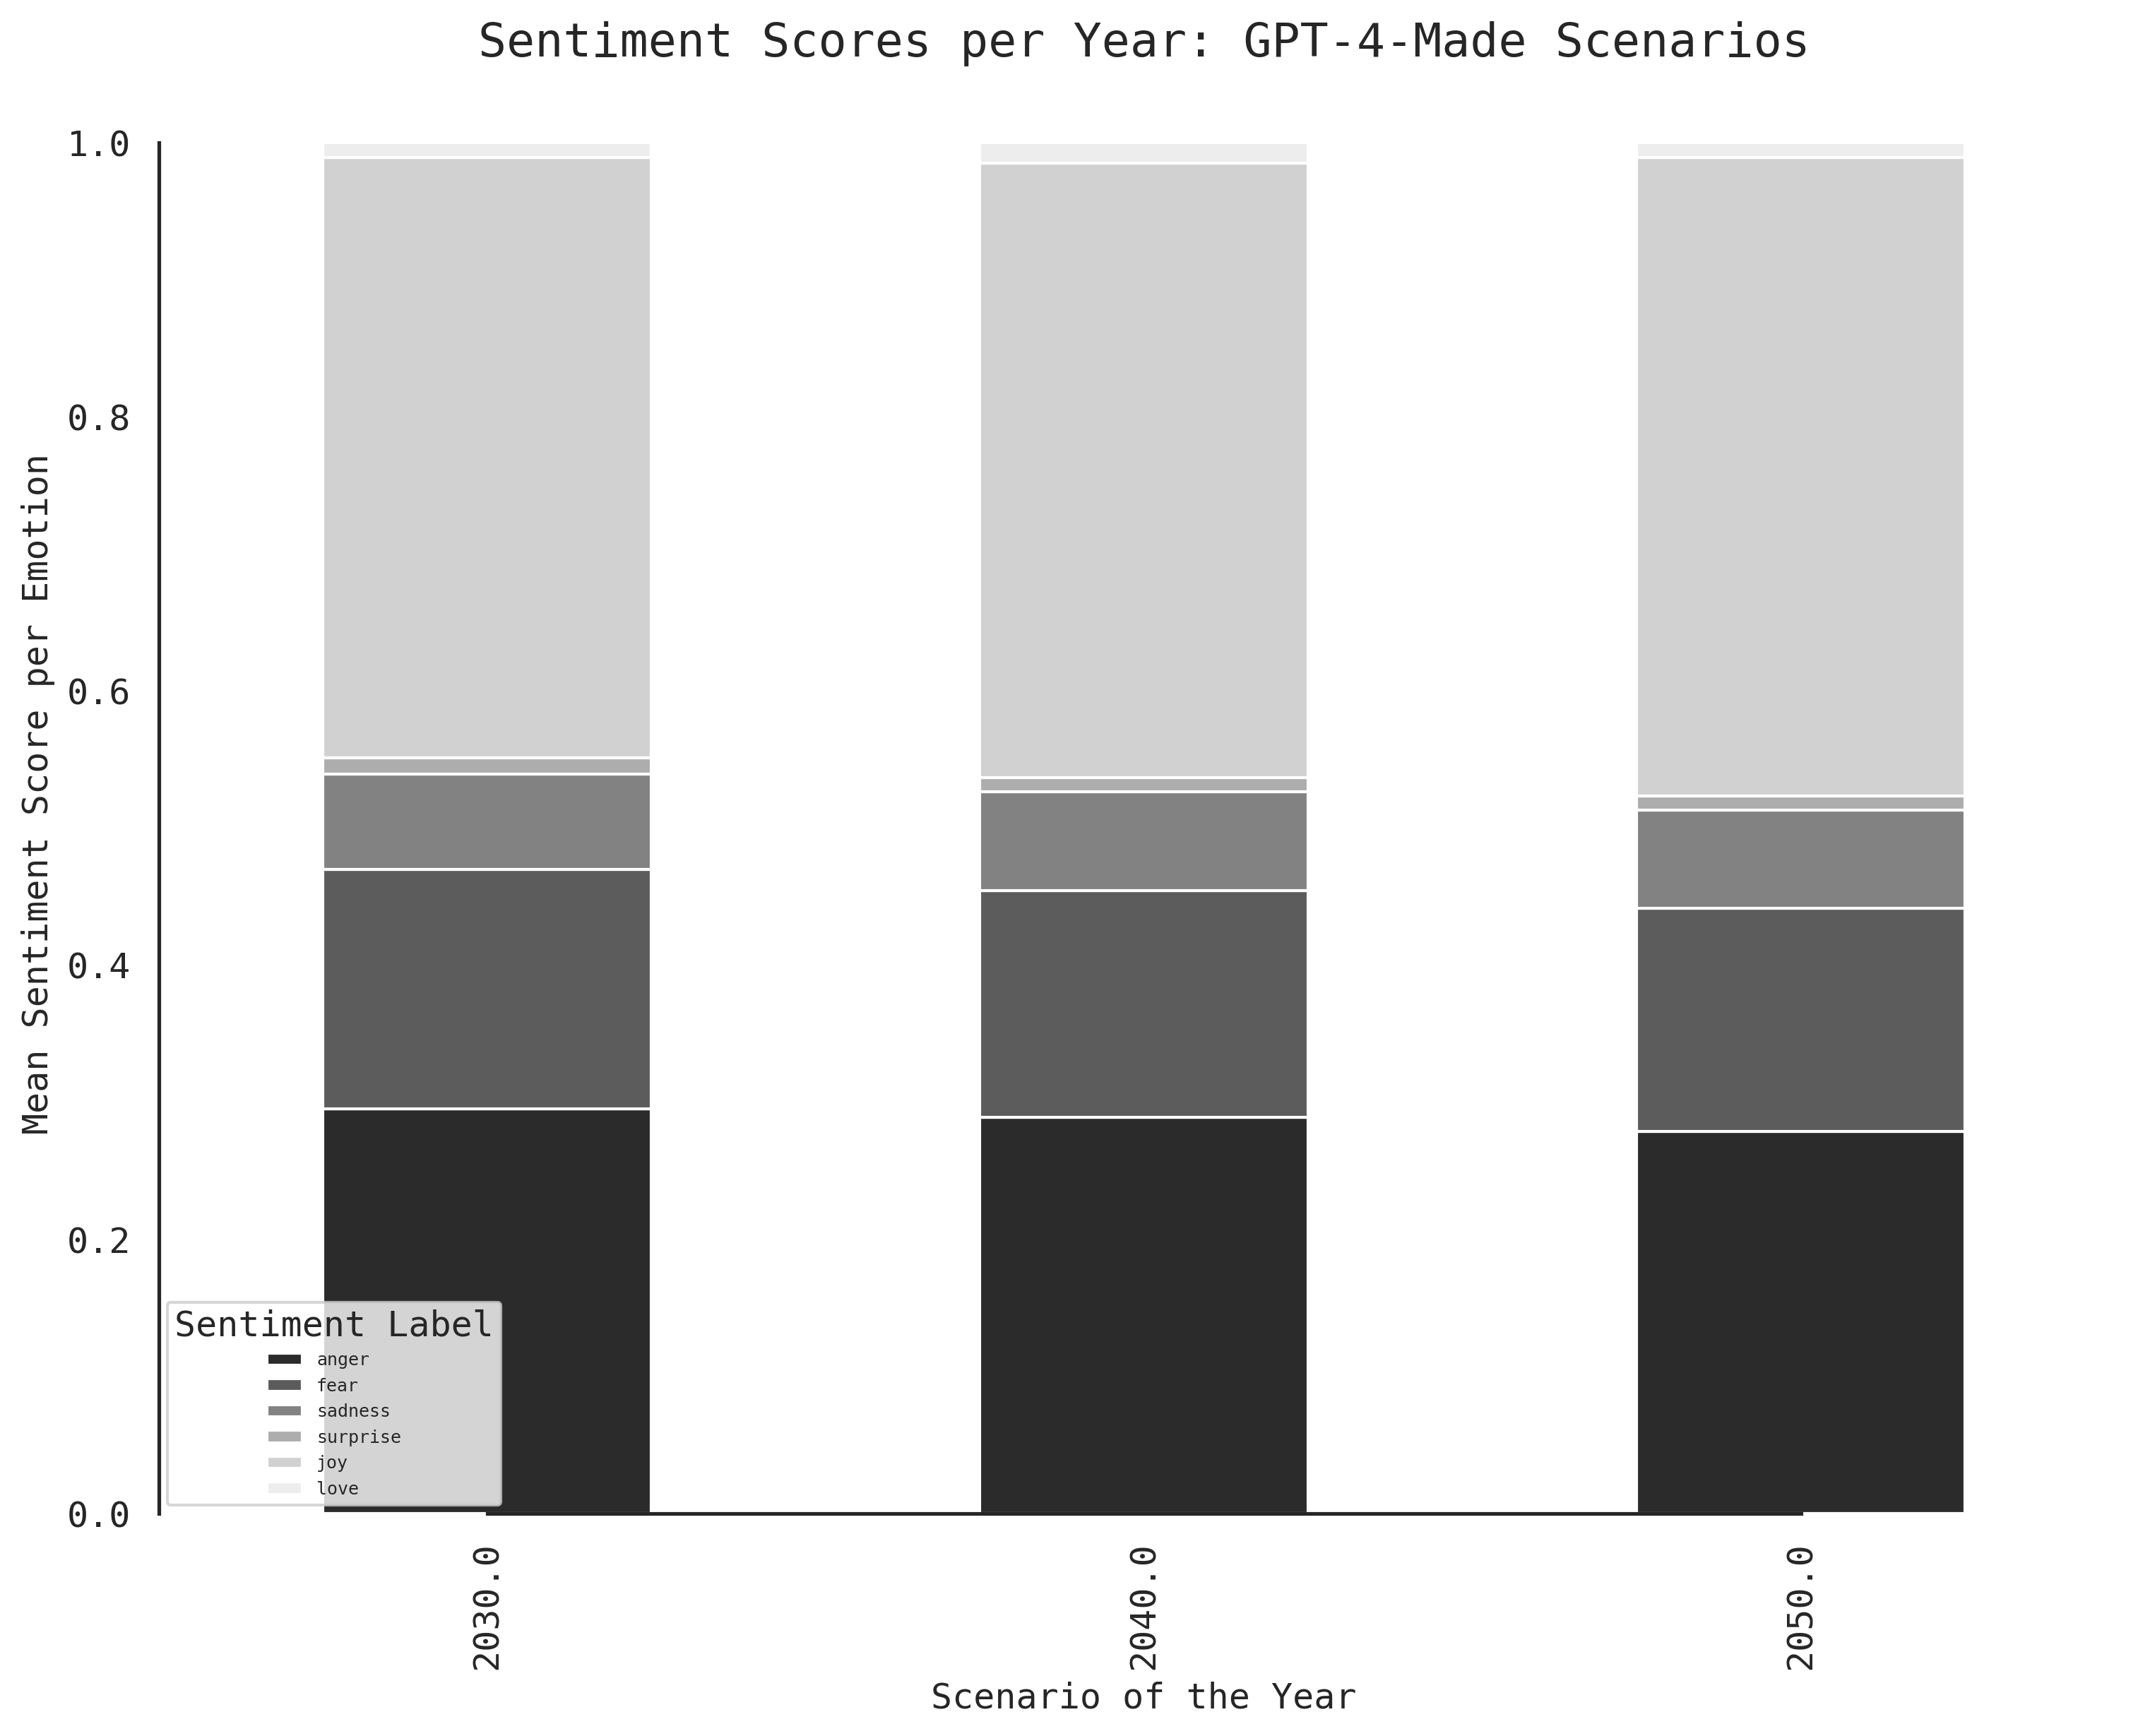

In [235]:
def visualize_grouped_sentiments(ss_emotions):
    # Melt the data frame to have sentiment labels as columns
    df_melted = pd.melt(ss_emotions, id_vars=["scenario", "year"], value_vars=["sadness", "joy", "love", "anger", "fear", "surprise"])
    
    # Pivot the data so that each sentiment label is a column and each group is a row
    pivot_df = df_melted.pivot_table(index='year', columns='variable', values='value', aggfunc='mean')
    
    # Re-order the columns in the pivot table
    pivot_df = pivot_df[["anger", "fear", "sadness", "surprise", "joy", "love"]]
    
    # Set the color palette to RdBu
    sns.set_palette("Greys_r", n_colors=6)
    
    # Set the style to whitegrid
    sns.set_style("white")
    
    # Set the font family to monospace
    mpl.rcParams['font.family'] = 'monospace'
    
    # Plot the stacked bar plot
    fig, ax = plt.subplots(figsize=(12, 9), dpi=300)
    pivot_df.plot(kind='bar', stacked=True, ax=ax)
    
    # Add labels and titles
    ax.set_title("Sentiment Scores per Year: GPT-4-Made Scenarios", fontsize=16)
    ax.set_xlabel("Scenario of the Year", fontsize=12)
    ax.set_ylabel("Mean Sentiment Score per Emotion", fontsize=12)
    ax.legend(title='Sentiment Label', fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Remove spines
    sns.despine(trim=True)
    
    plt.show()
    
visualize_grouped_sentiments(ss_emotions)

## Comparing both, Human-Made and Machine-Made Scenarios

In [236]:
hs_emotions = pd.read_csv('../Szenario/humanmade_scenarios_sentiment_analysis_full.csv')

In [237]:
hs_emotions = hs_emotions.drop(hs_emotions[(hs_emotions.year == 2035) | (hs_emotions.year == 2045)].index)

In [251]:
hs_emotions = hs_emotions.dropna()
hs_emotions.head()

,Unnamed: 0,year,scenario,sadness,joy,love,anger,fear,surprise
0,0,2030.0,"the eu27 continues to focus on jobs, growth an...",0.110962,0.203277,0.020045,0.473060,0.174097,0.018560
1,1,2030.0,the conditions for addressing societal challen...,0.041822,0.157424,0.010519,0.583284,0.197225,0.009726
2,2,2030.0,investors can benefit from the company's growt...,0.001149,0.994854,0.000743,0.001379,0.000703,0.001172
3,3,2030.0,"strategic investments, for example in the cons...",0.182399,0.479564,0.016541,0.267791,0.047464,0.006240
4,4,2030.0,the point of frugal innovations is not just to...,0.198535,0.111243,0.004060,0.313168,0.363654,0.009339


In [248]:
s35_emotions = pd.read_csv('../Szenario/gpt35_scenarios_sentiment_analysis_full.csv')

In [250]:
s35_emotions = s35_emotions.dropna()
s35_emotions.head()

,Unnamed: 0,year,scenario,sadness,joy,love,anger,fear,surprise
0,0,2030.0,students will attend virtual classes more freq...,0.032553,0.102700,0.007352,0.472149,0.373660,0.011587
1,1,2030.0,virtual reality and augmented reality will be ...,0.182399,0.479564,0.016541,0.267791,0.047464,0.006240
2,2,2030.0,artificial intelligence will be used to person...,0.055468,0.190905,0.008557,0.591155,0.147028,0.006888
3,3,2030.0,traditional textbooks will be replaced by e-bo...,0.024764,0.878412,0.004745,0.058631,0.029225,0.004222
4,4,2030.0,online assessments will replace traditional pa...,0.049031,0.205655,0.008676,0.270234,0.443068,0.023336


In [245]:
#hs_emotions = pd.read_csv('Szenario/humanmade_scenarios_sentiment_analysis_full.csv')
#ss_emotions = pd.read_csv('Szenario/machinemade_scenarios_sentiment_analysis_full.csv')

In [260]:
def visualize_grouped_sentiments(s35_emotions, ss_emotions, hs_emotions):
    # Melt the data frame to have sentiment labels as columns
    df_melted1 = pd.melt(ss_emotions, id_vars=["scenario", "year"], value_vars=["sadness", "joy", "love", "anger", "fear", "surprise"])
    df_melted2 = pd.melt(s35_emotions, id_vars=["scenario", "year"], value_vars=["sadness", "joy", "love", "anger", "fear", "surprise"])
    df_melted3 = pd.melt(hs_emotions, id_vars=["scenario", "year"], value_vars=["sadness", "joy", "love", "anger", "fear", "surprise"])
    
    # Pivot the data so that each sentiment label is a column and each group is a row
    pivot_df1 = df_melted1.pivot_table(index='year', columns='variable', values='value', aggfunc='mean')
    pivot_df2 = df_melted2.pivot_table(index='year', columns='variable', values='value', aggfunc='mean')
    pivot_df3 = df_melted2.pivot_table(index='year', columns='variable', values='value', aggfunc='mean')
    
    # Re-order the columns in the pivot table
    pivot_df1 = pivot_df1[["anger", "fear", "sadness", "surprise", "joy", "love"]]
    pivot_df2 = pivot_df2[["anger", "fear", "sadness", "surprise", "joy", "love"]]
    pivot_df3 = pivot_df2[["anger", "fear", "sadness", "surprise", "joy", "love"]]
    
    # Concatenate both pivot tables along the index, and label each data source
    pivot_df = pd.concat([pivot_df1, pivot_df2, pivot_df3], axis=0, keys=["GPT-4","GPT-3.5","Human"])
    
    # Set the color palette to RdBu
    sns.set_palette("Greys_r", n_colors=6)
    
    # Plot the stacked bar plot
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    pivot_df.plot(kind='bar', stacked=True, ax=ax)
    
    # Add labels and titles
    ax.set_title("Sentiment Scores per Year: Machine-Made vs Human-Made Scenarios", fontsize=16)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Mean Sentiment Score per Emotion", fontsize=10)
    ax.legend(title='Sentiment Label', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Remove spines
    sns.despine(trim=True)
    
    plt.show()

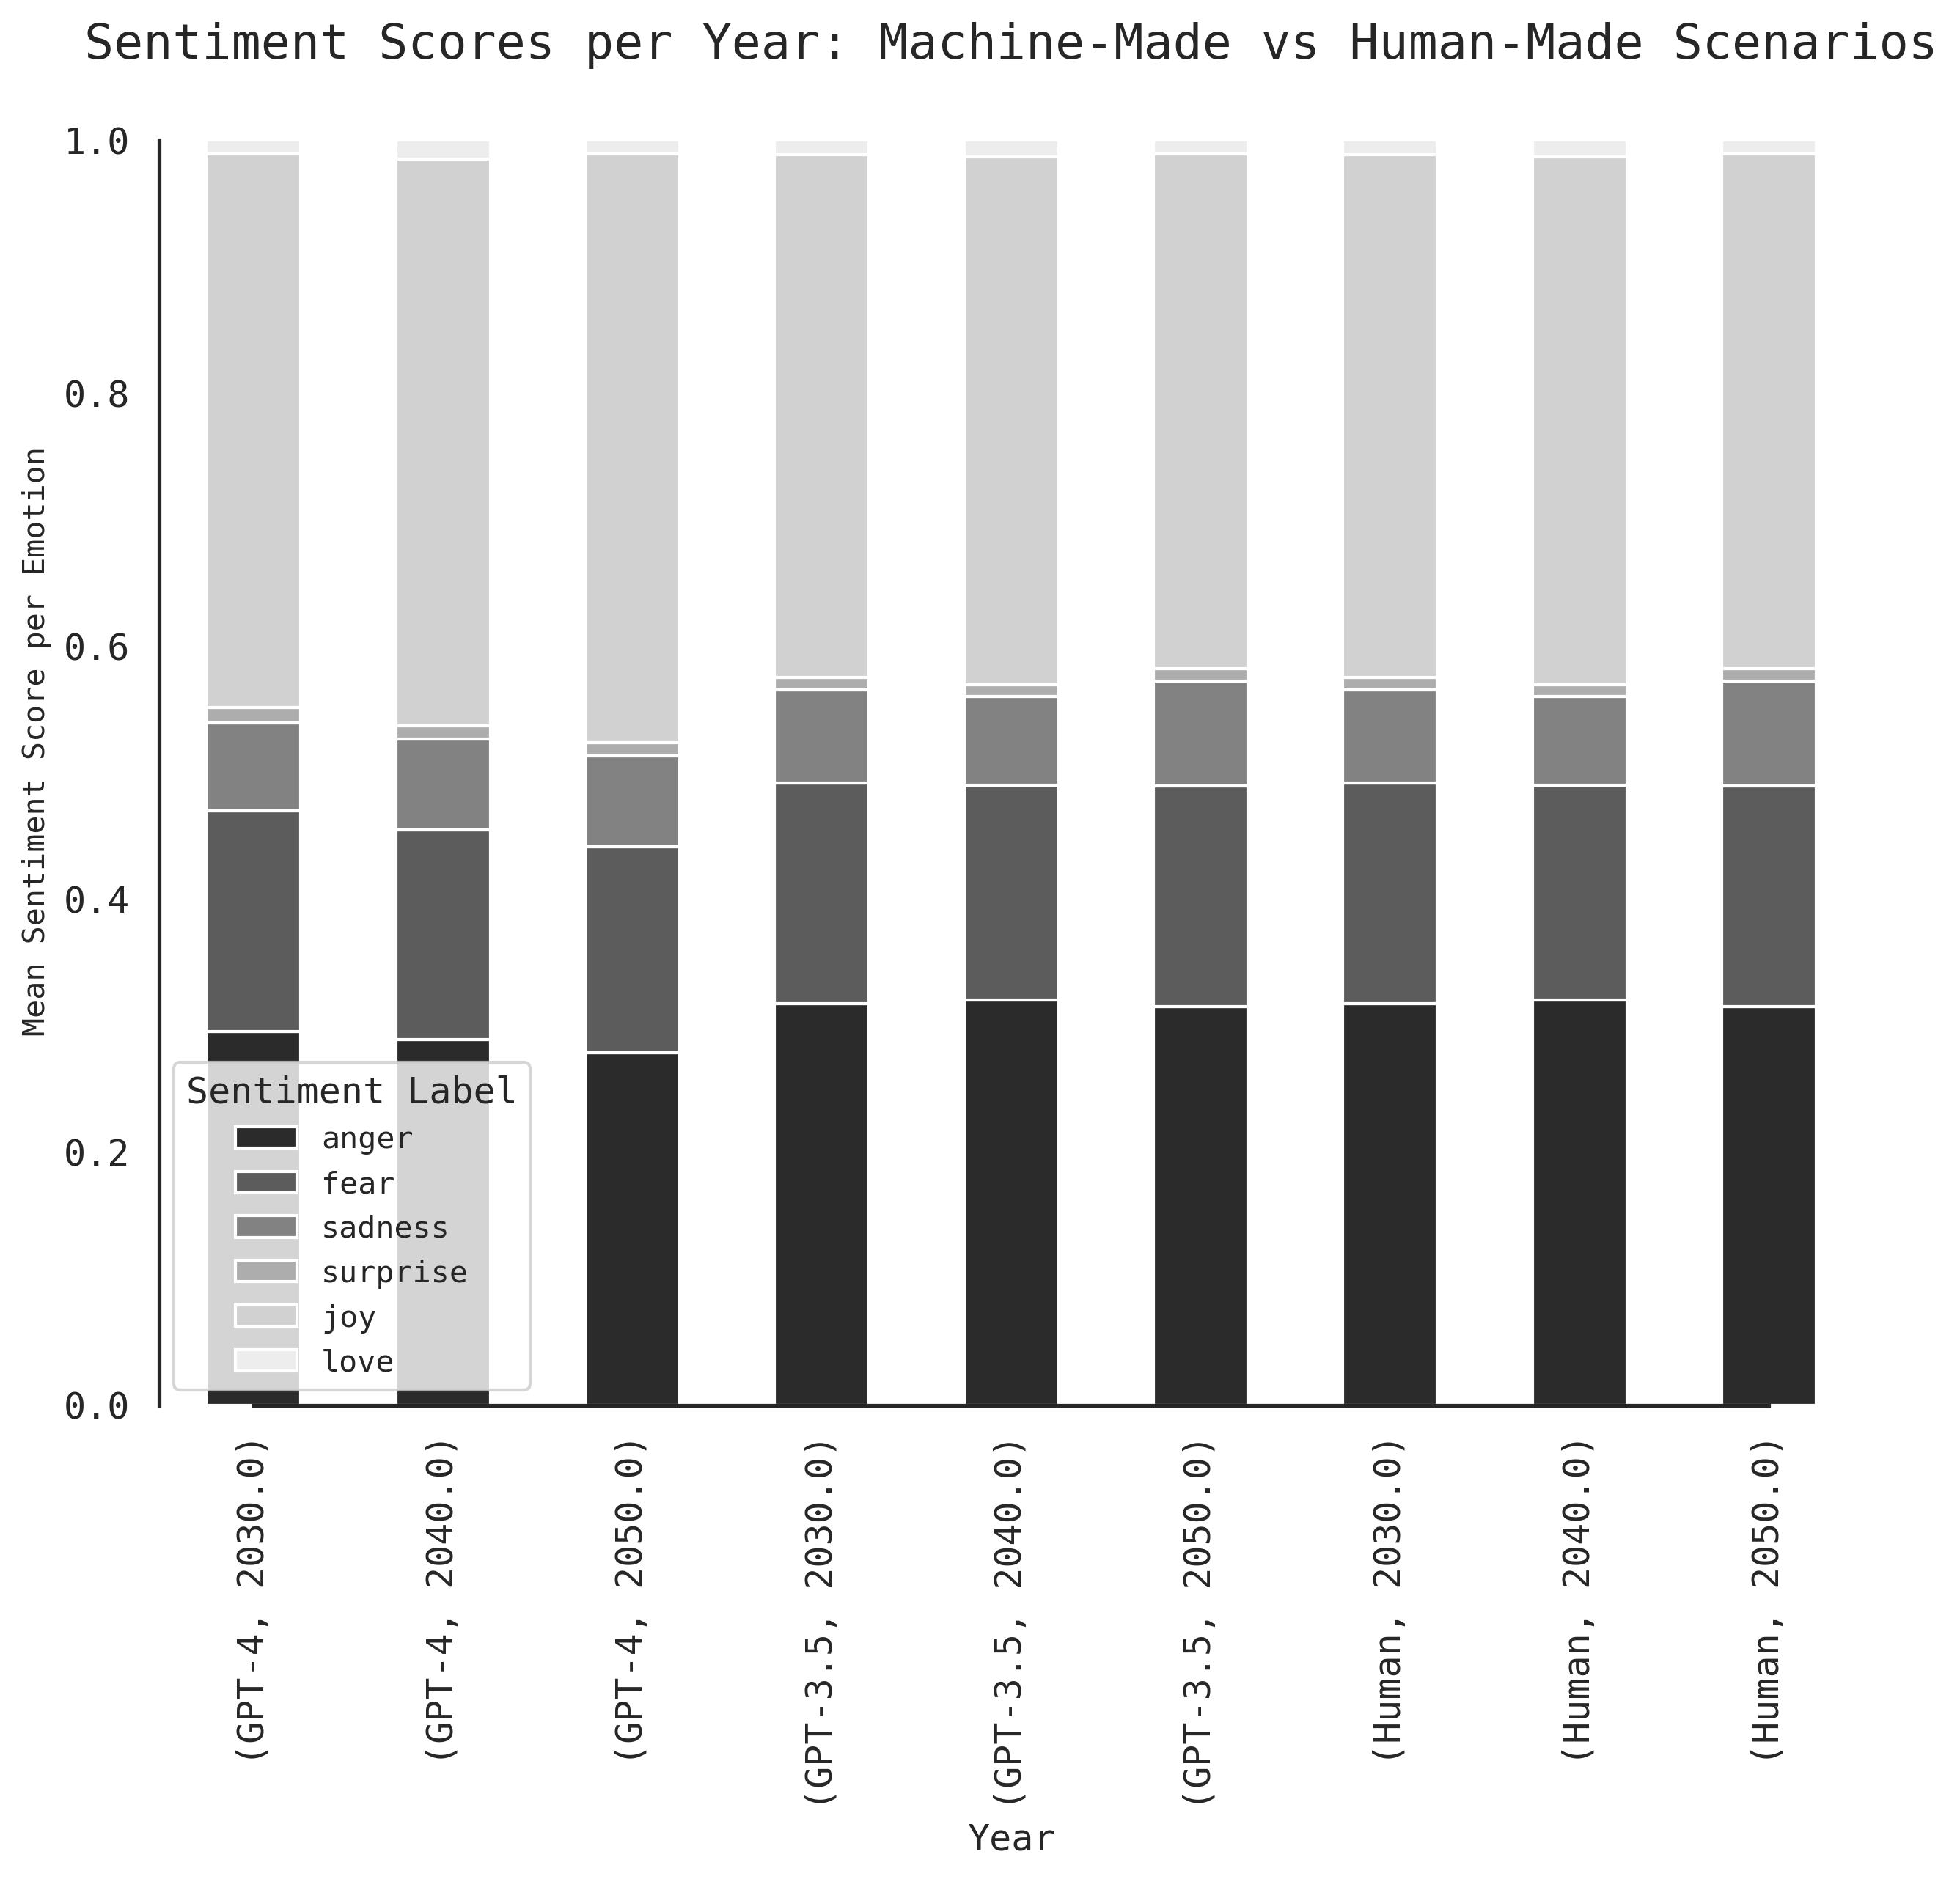

In [261]:
visualize_grouped_sentiments(s35_emotions, ss_emotions, hs_emotions)

## T-Test per Sentiment

In [272]:
from scipy.stats import ttest_ind

In [273]:
hs_sadness = hs_emotions['sadness']
ss_sadness = ss_emotions['sadness']

t_stat, p_val = ttest_ind(hs_sadness, ss_sadness, equal_var=False)

print("P-value: ", p_val)

P-value:  0.0007682242594389485


In [275]:
hs_sadness = hs_emotions['sadness']
s35_sadness = s35_emotions['sadness']

t_stat, p_val = ttest_ind(hs_sadness, s35_sadness, equal_var=False)

print("P-value: ", p_val)

P-value:  0.008225804401787058


In [265]:
hs_fear = hs_emotions['fear']
ss_fear = ss_emotions['fear']

t_stat, p_val = ttest_ind(hs_fear, ss_fear, equal_var=False)

print("P-value: ", p_val)

P-value:  0.04003111218991455


In [276]:
hs_fear = hs_emotions['fear']
s35_fear = s35_emotions['fear']

t_stat, p_val = ttest_ind(hs_fear, s35_fear, equal_var=False)

print("P-value: ", p_val)

P-value:  0.15855360764798196


In [266]:
hs_anger = hs_emotions['anger']
ss_anger = ss_emotions['anger']

t_stat, p_val = ttest_ind(hs_anger, ss_anger, equal_var=False)

print("P-value: ", p_val)

P-value:  5.174194068414625e-08


P-value:  0.00000005174194068414625

In [267]:
hs_anger = hs_emotions['anger']
s35_anger = s35_emotions['anger']

t_stat, p_val = ttest_ind(hs_anger, s35_anger, equal_var=False)

print("P-value: ", p_val)

P-value:  0.007938535595438037


In [268]:
hs_surprise = hs_emotions['surprise']
ss_surprise = ss_emotions['surprise']

t_stat, p_val = ttest_ind(hs_surprise, ss_surprise, equal_var=False)

print("P-value: ", p_val)

P-value:  0.5742040539425568


In [277]:
hs_surprise = hs_emotions['surprise']
s35_surprise = s35_emotions['surprise']

t_stat, p_val = ttest_ind(hs_surprise, s35_surprise, equal_var=False)

print("P-value: ", p_val)

P-value:  0.42210943661902856


In [269]:
hs_joy = hs_emotions['joy']
ss_joy = ss_emotions['joy']

t_stat, p_val = ttest_ind(hs_joy, ss_joy, equal_var=False)

print("P-value: ", p_val)

P-value:  6.897228642655168e-13


P-value:  0.0000000000006897228642655168

In [278]:
hs_joy = hs_emotions['joy']
s35_joy = s35_emotions['joy']

t_stat, p_val = ttest_ind(hs_joy, s35_joy, equal_var=False)

print("P-value: ", p_val)

P-value:  1.0639088602384985e-05


P-value:  0.000010639088602384985

In [270]:
hs_love = hs_emotions['love']
ss_love = ss_emotions['love']

t_stat, p_val = ttest_ind(hs_love, ss_love, equal_var=False)

print("P-value: ", p_val)

P-value:  0.9113426032694475


In [279]:
hs_love = hs_emotions['love']
s35_love = s35_emotions['love']

t_stat, p_val = ttest_ind(hs_love, s35_love, equal_var=False)

print("P-value: ", p_val)

P-value:  0.9252810429131844


# LDA

Now that I have a trained model let’s visualize the topics for interpretability. To do so, 
I’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

you can manually select each topic to view its top most frequent and/or “relevant” terms, using 
different values of the λ parameter. This can help when you’re trying to assign a human 
interpretable name or “meaning” to each topic'

In [23]:
import gensim.corpora as corpora
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dianakozachek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
titles = list(scenario['scenario_singlewords'])

In [25]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

data_words = remove_stopwords(titles)

print(data_words[:1][0][-1])

negotiation


In [26]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][-1])

(8, 1)


In [27]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"area" + 0.008*"innovation" + 0.008*"consumption" + 0.005*"global" + '
  '0.005*"still" + 0.005*"research" + 0.004*"sustainable" + 0.004*"life" + '
  '0.004*"production" + 0.004*"used"'),
 (1,
  '0.008*"innovation" + 0.006*"digital" + 0.005*"service" + 0.005*"access" + '
  '0.005*"technology" + 0.005*"health" + 0.005*"global" + 0.005*"social" + '
  '0.004*"system" + 0.004*"via"'),
 (2,
  '0.010*"consumption" + 0.008*"social" + 0.008*"global" + 0.006*"research" + '
  '0.006*"city" + 0.006*"country" + 0.005*"online" + 0.005*"sustainable" + '
  '0.005*"innovation" + 0.005*"health"'),
 (3,
  '0.012*"global" + 0.008*"world" + 0.008*"health" + 0.007*"product" + '
  '0.007*"people" + 0.007*"population" + 0.007*"country" + 0.006*"society" + '
  '0.006*"city" + 0.005*"system"'),
 (4,
  '0.010*"social" + 0.009*"change" + 0.008*"innovation" + 0.007*"research" + '
  '0.006*"development" + 0.006*"form" + 0.005*"technology" + 0.005*"digital" + '
  '0.005*"way" + 0.005*"life"'),
 (5,
  

In [28]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [29]:
vis = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=20)
vis

/Users/dianakozachek/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.000612  0.017230       1        1  12.077888
4      0.017414 -0.126332       2        1  11.620565
6     -0.117801 -0.049419       3        1  10.752130
3     -0.074806  0.138838       4        1  10.581234
9      0.114588 -0.109981       5        1  10.479642
2      0.127314 -0.017880       6        1  10.184118
7      0.036577  0.146714       7        1   9.303649
8     -0.073934 -0.129715       8        1   8.895219
1     -0.153686  0.045854       9        1   8.187222
0      0.124946  0.084689      10        1   7.918335, topic_info=             Term       Freq      Total Category  logprob  loglift
332   consumption  40.000000  40.000000  Default  20.0000  20.0000
95          death  16.000000  16.000000  Default  19.0000  19.0000
488          work  26.000000  26.000000  Default  18.0000  18.0000
141          area  43.000000  43.000000  Default  17.0000  17.0000
1389      product  31.000000  31.000000  Default  16.0000  16.0000
...           ...        ...        ...      ...      ...      ...
194        change   4.150809  40.597760  Topic10  -5.5227   0.2556
231       economy   3.896997  32.205065  Topic10  -5.5858   0.4241
130      economic   3.457387  43.410916  Topic10  -5.7055   0.0058
386        system   3.345943  50.582161  Topic10  -5.7382  -0.1799
380       science   3.203262  24.620559  Topic10  -5.7818   0.4966

[569 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
420      10  0.650357  acceptance
9         6  0.322978    accepted
9        10  0.645956    accepted
201       1  0.070517      access
201       2  0.105776      access
...     ...       ...         ...
948       3  0.096672        year
948       4  0.193344        year
948       5  0.193344        year
948       8  0.290017        year
949       5  0.833361     younger

[1511 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 7, 4, 10, 3, 8, 9, 2, 1])

## Keyword Extraktion

In [30]:
from rake_nltk import Rake
import itertools

In [31]:
flat_list = list(itertools.chain.from_iterable(titles))

In [52]:
text = ', '.join(flat_list)

In [44]:
r = Rake()
r.extract_keywords_from_text(text)
keywords = r.get_ranked_phrases()
word_counts = Counter(keywords)
print(word_counts)

Counter({'social': 122, 'innovation': 122, 'global': 106, 'research': 87, 'people': 81, 'society': 78, 'knowledge': 65, 'system': 63, 'health': 60, 'country': 60, 'life': 57, 'world': 56, 'city': 56, 'economic': 54, 'area': 54, 'service': 51, 'consumption': 51, 'change': 50, 'development': 48, 'citizen': 48, 'digital': 47, 'increase': 46, 'population': 44, 'form': 44, 'effect': 44, 'increasingly': 43, 'urban': 42, 'technology': 41, 'increased': 40, 'economy': 40, 'product': 39, 'market': 38, 'also': 38, 'need': 37, 'good': 36, 'access': 35, 'education': 34, 'due': 34, 'towards': 33, 'common': 33, 'work': 32, 'individual': 32, 'challenge': 32, 'many': 31, 'financial': 31, 'environmental': 31, 'sustainable': 30, 'science': 30, 'data': 30, 'production': 29, 'private': 29, 'political': 29, 'online': 29, 'internet': 29, 'climate': 29, 'well': 28, 'used': 28, 'still': 28, 'public': 28, 'time': 27, 'resource': 27, 'process': 27, 'open': 27, 'material': 27, 'information': 27, 'led': 26, 'drive